<a href="https://colab.research.google.com/github/ymuto0302/RW2024/blob/main/PyTorch_CNN_CIFER_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for CIFER10
CIFAR-10とは，10のクラス（飛行機，自動車，鳥，猫，鹿，犬，カエル，馬，船，トラック）に分類された6万枚のカラー画像から構成されるデータセットである。各画像は32x32ピクセルのサイズである。

CIFAR10では，60000のイメージがあり，そのうち50000が訓練用で，10000がテスト用とされている。

以下は CIFER10 データセットを畳み込みニューラルネットワーク(CNN)により分類するコードである。

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# GPUが利用可能であればGPUを、そうでなければCPUを使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データの前処理とaugmentationの定義
transform = transforms.Compose([
    transforms.ToTensor(),  # PIL Image をテンソルに変換
])

# 訓練データとテストデータの準備
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# モデル (CNN) の定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# モデルのインスタンス化
model = Net()
# model.fc = nn.Linear(model.fc.in_features, 10)  # 最終層を CIFAR10 の10クラスに合わせて調整
model = model.to(device)  # モデルをGPUまたはCPUに移動

# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練ループ
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()  # モデルを訓練モードに設定
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # データをGPUまたはCPUに移動

            optimizer.zero_grad()  # 勾配をゼロに初期化
            outputs = model(inputs)  # 順伝播
            loss = criterion(outputs, labels)  # 損失の計算
            loss.backward()  # 逆伝播
            optimizer.step()  # パラメータの更新

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # 評価フェーズ
        model.eval()  # モデルを評価モードに設定
        correct = 0
        total = 0
        with torch.no_grad():  # 勾配計算を無効化
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)  # 最大値のインデックス（予測クラス）を取得
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

    return model

# 推論関数の定義
def predict(model, image):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():  # 勾配計算を無効化
        image = image.unsqueeze(0).to(device)  # バッチ次元を追加し、デバイスに移動
        output = model(image)
        _, predicted = torch.max(output, 1)  # 最大値のインデックス（予測クラス）を取得
    return predicted.item()

# モデルの訓練
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer)

# 推論の使用例
sample_image, _ = test_dataset[0]
prediction = predict(trained_model, sample_image)
print(f"Predicted class: {prediction}")


100%|██████████| 170498071/170498071 [00:05<00:00, 29364712.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/10, Loss: 1.8066, Accuracy: 0.4307
Epoch 2/10, Loss: 1.5117, Accuracy: 0.4667
Epoch 3/10, Loss: 1.4152, Accuracy: 0.5095
Epoch 4/10, Loss: 1.3418, Accuracy: 0.5238
Epoch 5/10, Loss: 1.2762, Accuracy: 0.5445
Epoch 6/10, Loss: 1.2227, Accuracy: 0.5606
Epoch 7/10, Loss: 1.1693, Accuracy: 0.5683
Epoch 8/10, Loss: 1.1327, Accuracy: 0.5759
Epoch 9/10, Loss: 1.0928, Accuracy: 0.5943
Epoch 10/10, Loss: 1.0652, Accuracy: 0.5978
Predicted class: 3


## (参考) CIFER10 に含まれる画像の表示

torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])


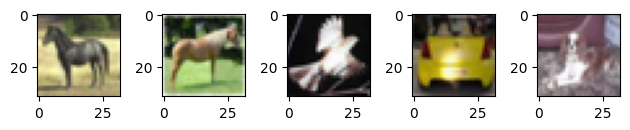

In [12]:
data = next(iter(train_loader))
print(data[0].shape) # torch.Size([64, 3, 32, 32])
print(data[0][0].shape) # torch.Size([3, 32, 32])

import matplotlib.pyplot as plt
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(data[0][i].permute(1, 2, 0))
plt.tight_layout()
plt.show()